# Coursera Course Analysis Project

# Data Preparation

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

### Reading the Data

In [2]:
data = pd.read_csv('coursera_data.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


### Checking for Missing Values and Duplicates

In [4]:
data.isna().any().any()

False

In [5]:
data.duplicated().any()

False

There are no duplicates nor missing values.

# Reformatting the Data

The 'course_students_enrolled' column uses the pattern number + (k or m) to denote the number of enrolled students. Here the letter k stands for thousands and m for millions.\
In order to perform numerical operations, it is necessary to reformat this column.

In [6]:
data['course_students_enrolled'].str.endswith('k').all()

False

In [7]:
pd.DataFrame(data[np.invert(data['course_students_enrolled'].str.endswith('k'))]['course_students_enrolled'])

,course_students_enrolled
564,3.2m
674,1.3m
688,1.5m
815,2.5m


In [8]:
k_mask = data['course_students_enrolled'].str.endswith('k')
m_mask = data['course_students_enrolled'].str.endswith('m')
data['course_students_enrolled_numeric'] = pd.concat([
pd.to_numeric(data[k_mask]['course_students_enrolled'].str[:-1]) * 1E3,
pd.to_numeric(data[m_mask]['course_students_enrolled'].str[:-1]) * 1E6]).sort_index()

## Treating Outliers

There are two numerical labels where the outliers need to be aknowledged: __course_rating__ and __course_students_enrolled__.

### Course Rating

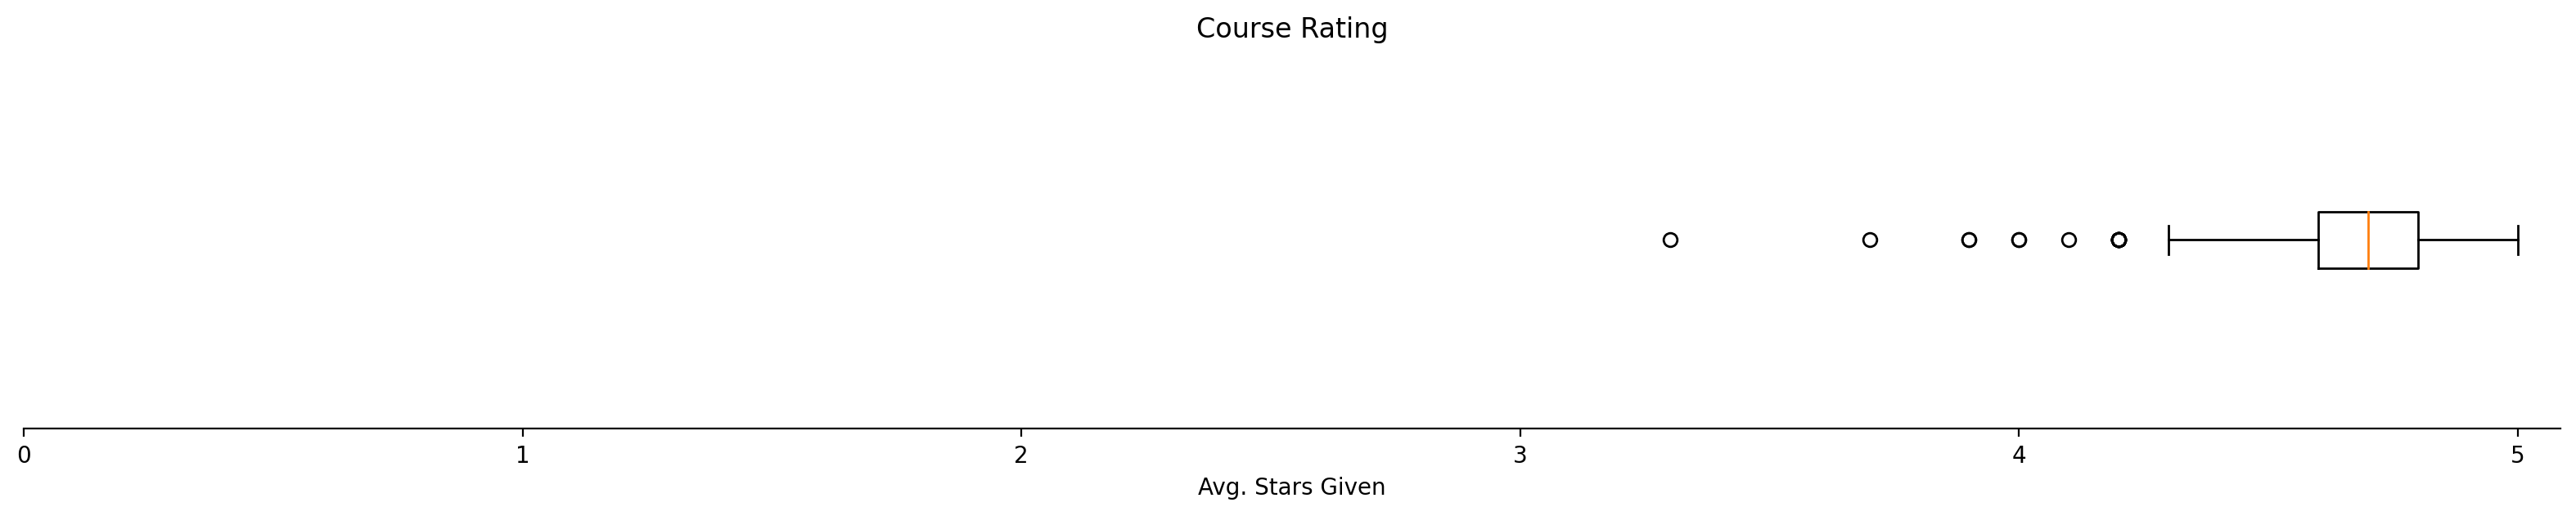

In [9]:
fig = plt.figure(figsize=(20,3), dpi=200)
ax = plt.gca()
ax.boxplot(data['course_rating'],vert=False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.spines[['top','left','right']].set_visible(False)
ax.set_title('Course Rating')
ax.set_xlabel('Avg. Stars Given')
ax.set_xlim(xmin=0);

While lower outliers are present in this feature, there's no indication that this data is flawed in any manner, as ratings of 3.3 or higher fall within the normal range.

### Course Students Enrolled

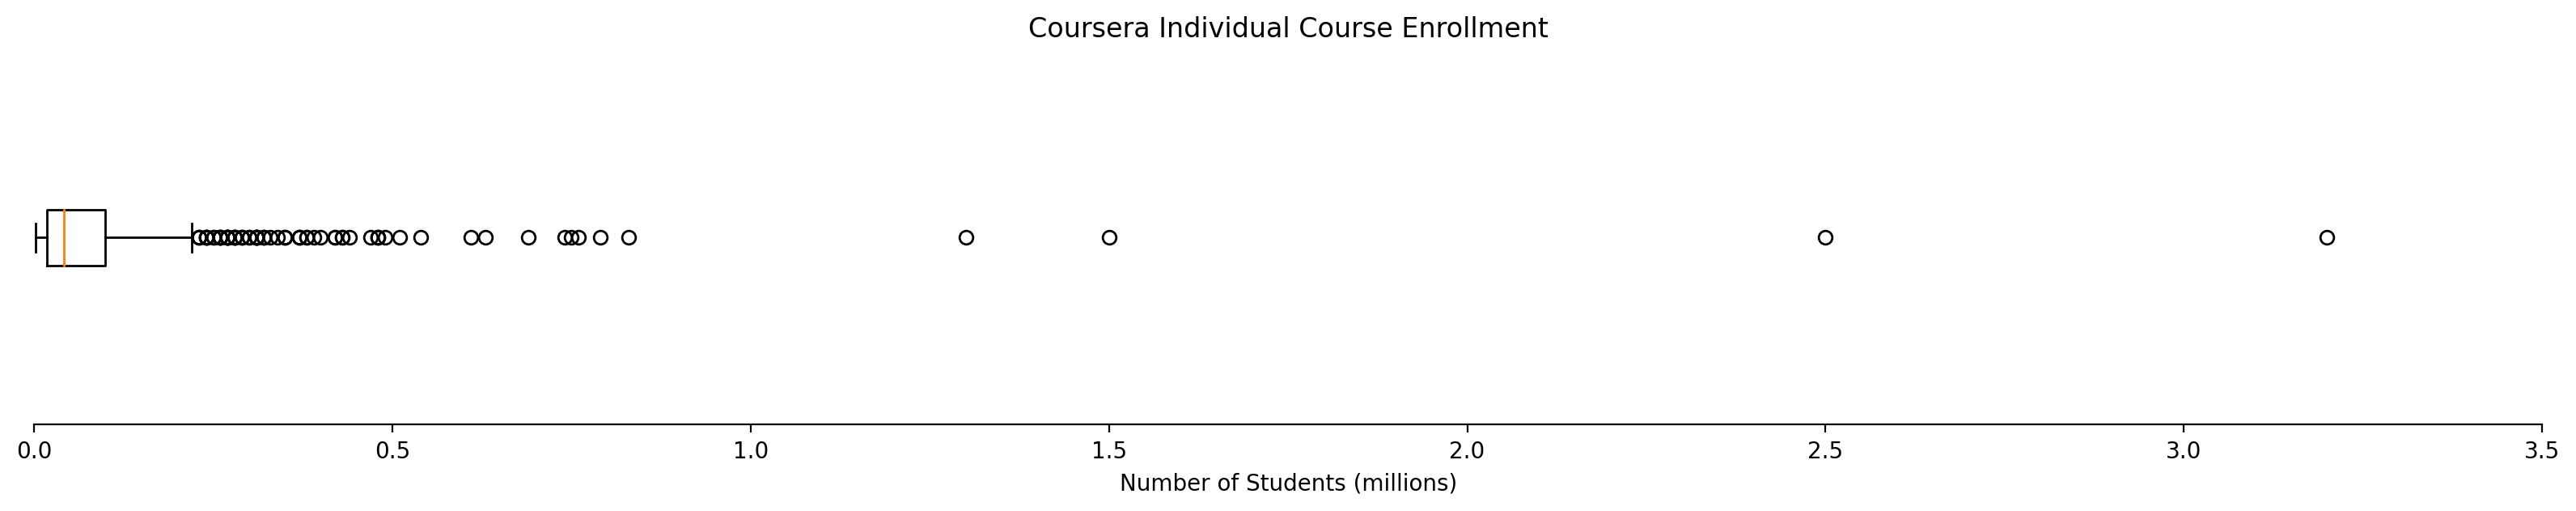

In [10]:
fig = plt.figure(figsize=(20,3),dpi=200)
ax = plt.gca()
ax.boxplot(data['course_students_enrolled_numeric'], vert=False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: x / 1E6))
ax.spines[['top','left','right']].set_visible(False)
ax.set_xlabel('Number of Students (millions)')
ax.set_title('Coursera Individual Course Enrollment')
ax.set_xlim(xmin=0, xmax=3.5E6);

In [11]:
q1,q3 = np.percentile(data['course_students_enrolled_numeric'],[25,75])
iqr = q3 - q1
data[data['course_students_enrolled_numeric'] > q3 + (1.5 * iqr)].sort_values(
'course_students_enrolled_numeric', ascending=False).head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3.2m,3200000.0
815,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m,2500000.0
688,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m,1500000.0
674,Programming for Everybody (Getting Started wit...,University of Michigan,COURSE,4.8,Mixed,1.3m,1300000.0
196,Data Science,Johns Hopkins University,SPECIALIZATION,4.5,Beginner,830k,830000.0


There seem to be nothing that would indicate errors in the data. Even among the largest outliers, given the size of Coursera's total users, the prestige of the publishing organizations and the demand for MOOC's (especially for Data Science, ML and Python) such enrollment sizes are probable.

# Exploratory Analysis

### Observations and Features

In [12]:
data.shape[0]

891

In [13]:
list(data.columns)

['course_title',
 'course_organization',
 'course_Certificate_type',
 'course_rating',
 'course_difficulty',
 'course_students_enrolled',
 'course_students_enrolled_numeric']

There are 2 numeric features (course_students_enrolled and course_rating) and 4 categorical features (course_title, course_organization, course_Certificate_type and course_difficulty).

## Title Keywords

In [14]:
from collections import Counter
full_list = list()
for i in data['course_title']:
    for word in i.split():
        full_list.append(word)
tokenized_titles = pd.DataFrame.from_dict(dict(Counter(full_list)), orient='index').sort_values(0, ascending=False).reset_index()
tokenized_titles = tokenized_titles[np.invert(tokenized_titles['index'].str.islower())]
tokenized_titles = tokenized_titles[np.invert(tokenized_titles['index'].str.contains('|'.join(['The','&'])))]
tokenized_titles.columns = ['Keyword','Count']

## Top 20 Title Keywords

In [15]:
tokenized_titles.head(20)

,Keyword,Count
3,Introduction,75
5,Data,69
9,Management,46
11,Science,36
12,Business,36
13,Python,34
14,Learning,32
15,Health,31
16,Google,29
17,Design,28


# Organizations

## Number of Organizations

In [16]:
len(data['course_organization'].unique())

154

## Top 20 Organizations by Number of Courses

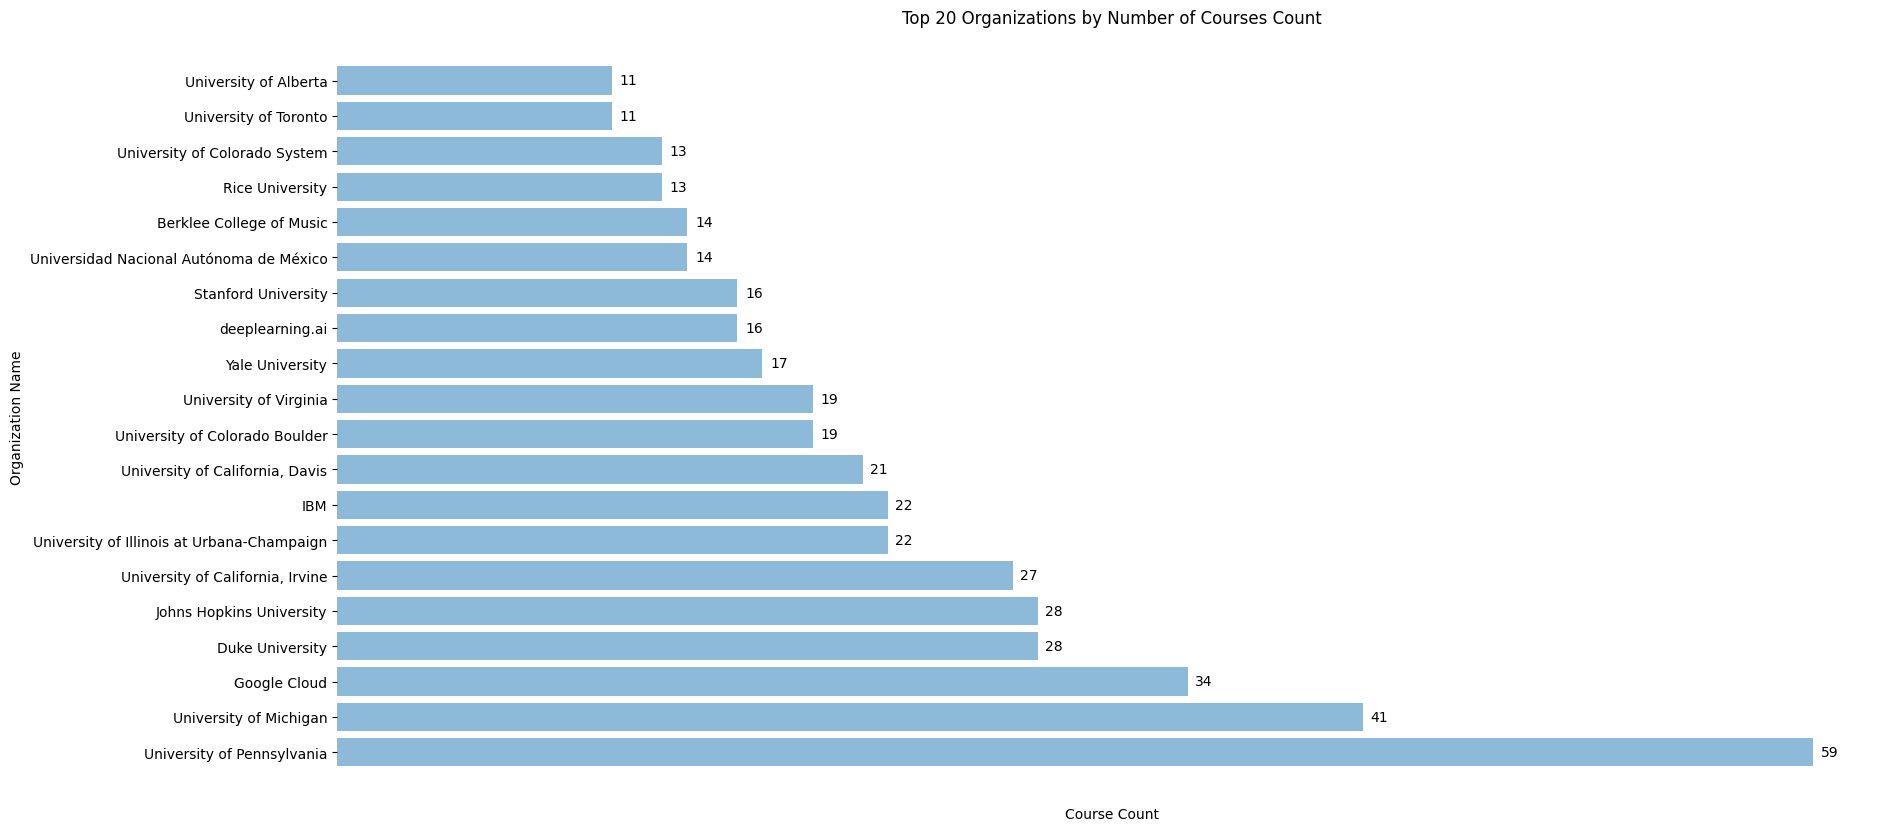

In [17]:
org_num = data.groupby('course_organization')['course_organization'].count().sort_values(ascending=False)
top_20_no_courses = org_num.iloc[:20]
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(top_20_no_courses.index, top_20_no_courses, alpha=0.5)
for i in range(20):
    ax.text(x=top_20_no_courses[i]+0.3, y=i, s=top_20_no_courses[i], va='center')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Top 20 Organizations by Number of Courses Count')
ax.set_ylabel('Organization Name')
ax.set_xlabel('Course Count');

Most productive organizations are American universities with an exception of UNA de Mexico, deeplearning.ai, IBM, and Google.

## Top 20 Organizations by Course Enrollment

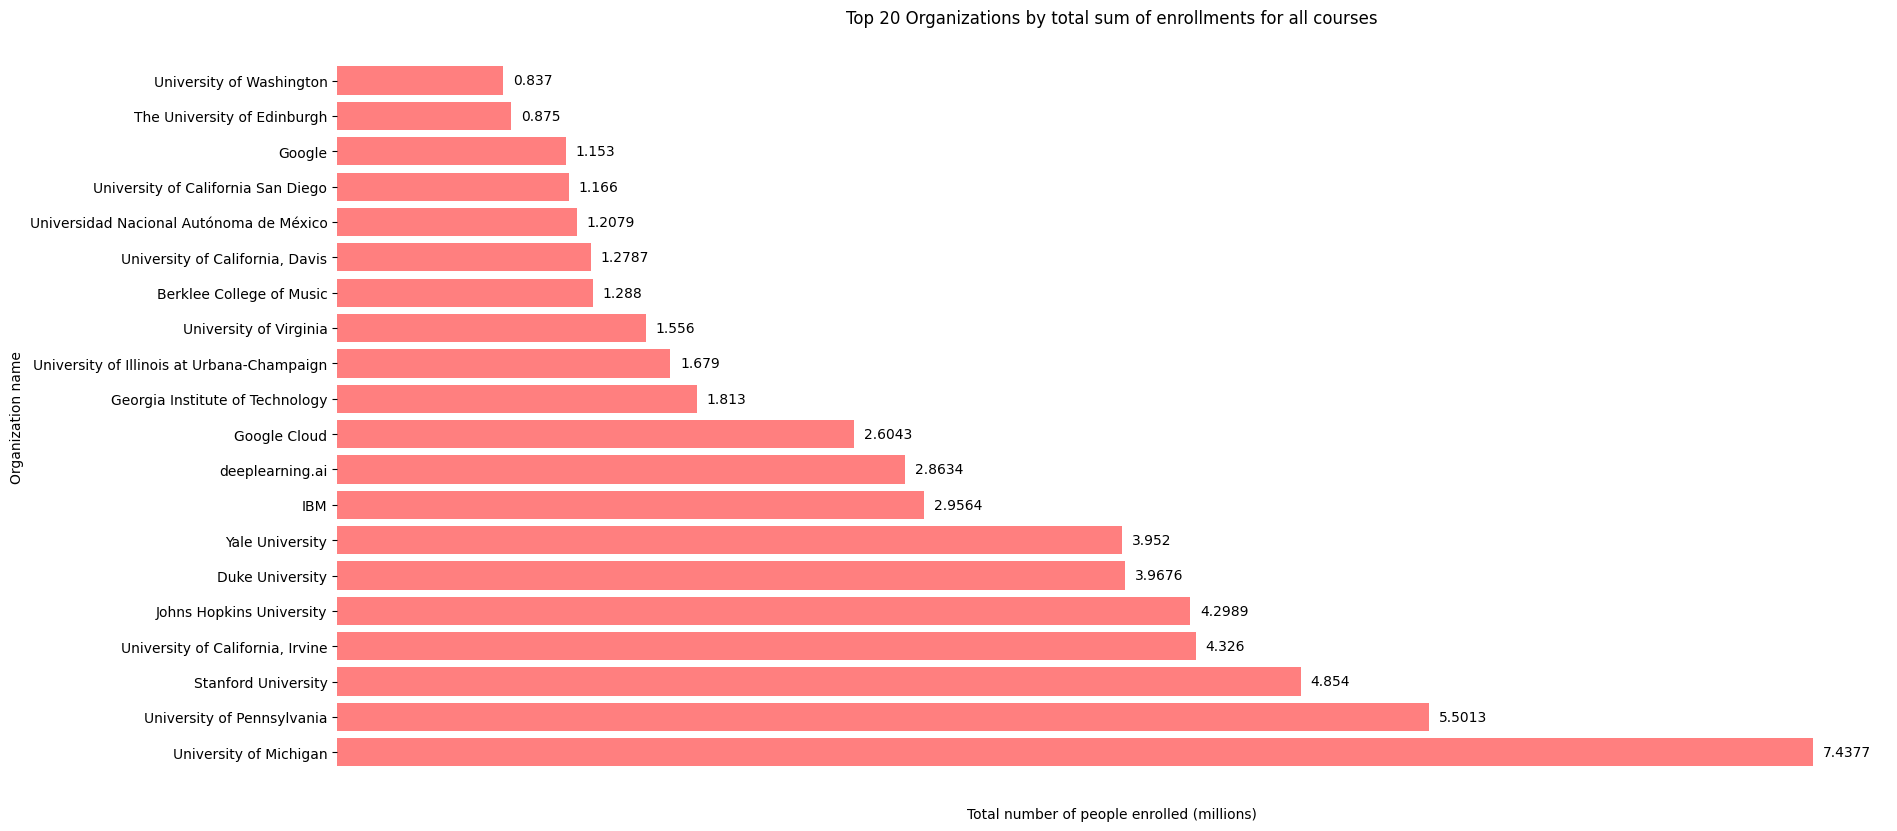

In [18]:
enroll_by_org = data.groupby('course_organization')['course_students_enrolled_numeric'].sum().sort_values(ascending=False)
top_20_enroll = enroll_by_org[:20]
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(top_20_enroll.index, top_20_enroll, alpha=0.5, color='red')
for i in range(20):
    ax.text(x=top_20_enroll[i]+5E4, y=i, s=f'{top_20_enroll[i]/1E6}', va='center')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Top 20 Organizations by total sum of enrollments for all courses')
ax.set_ylabel('Organization name')
ax.set_xlabel('Total number of people enrolled (millions)');

Most popular organizations are American universities with an exception of UNA de Mexico, deeplearning.ai, IBM, and Google.

## 50 Least Popular Organizations by Total Enrollment

In [19]:
least_popular_orgs = pd.DataFrame(
    data.groupby('course_organization')['course_students_enrolled_numeric'].sum().sort_values()).head(50)
least_popular_orgs

,course_students_enrolled_numeric
course_organization,
Automation Anywhere,2200.0
Peter the Great St. Petersburg Polytechnic University,2400.0
University of New Mexico,5500.0
ESCP Business School,6500.0
UCL School of Management,7800.0
Novosibirsk State University,8200.0
Crece con Google,8800.0
Palo Alto Networks,9100.0
Fundação Instituto de Administração,9200.0


It seems like the least popular institutions mostly consist of non-American universities and non university establisments.

# Dificulty Levels

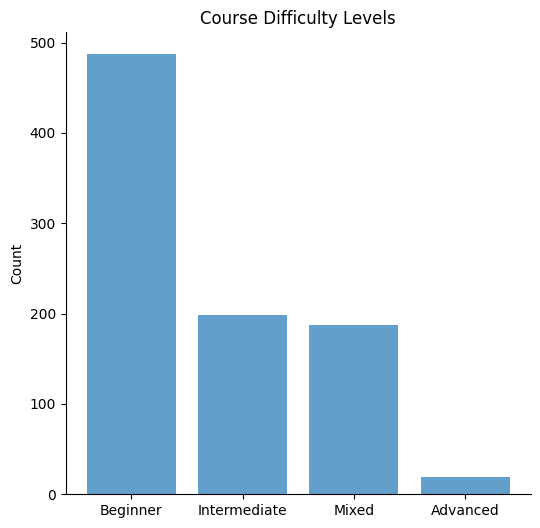

In [20]:
diffs = data['course_difficulty'].value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(diffs.index, diffs, alpha=0.7)
ax.spines[['top','right']].set_visible(False)
ax.set_title('Course Difficulty Levels')
ax.set_ylabel('Count');

## Students Enrolled per Course Difficulty

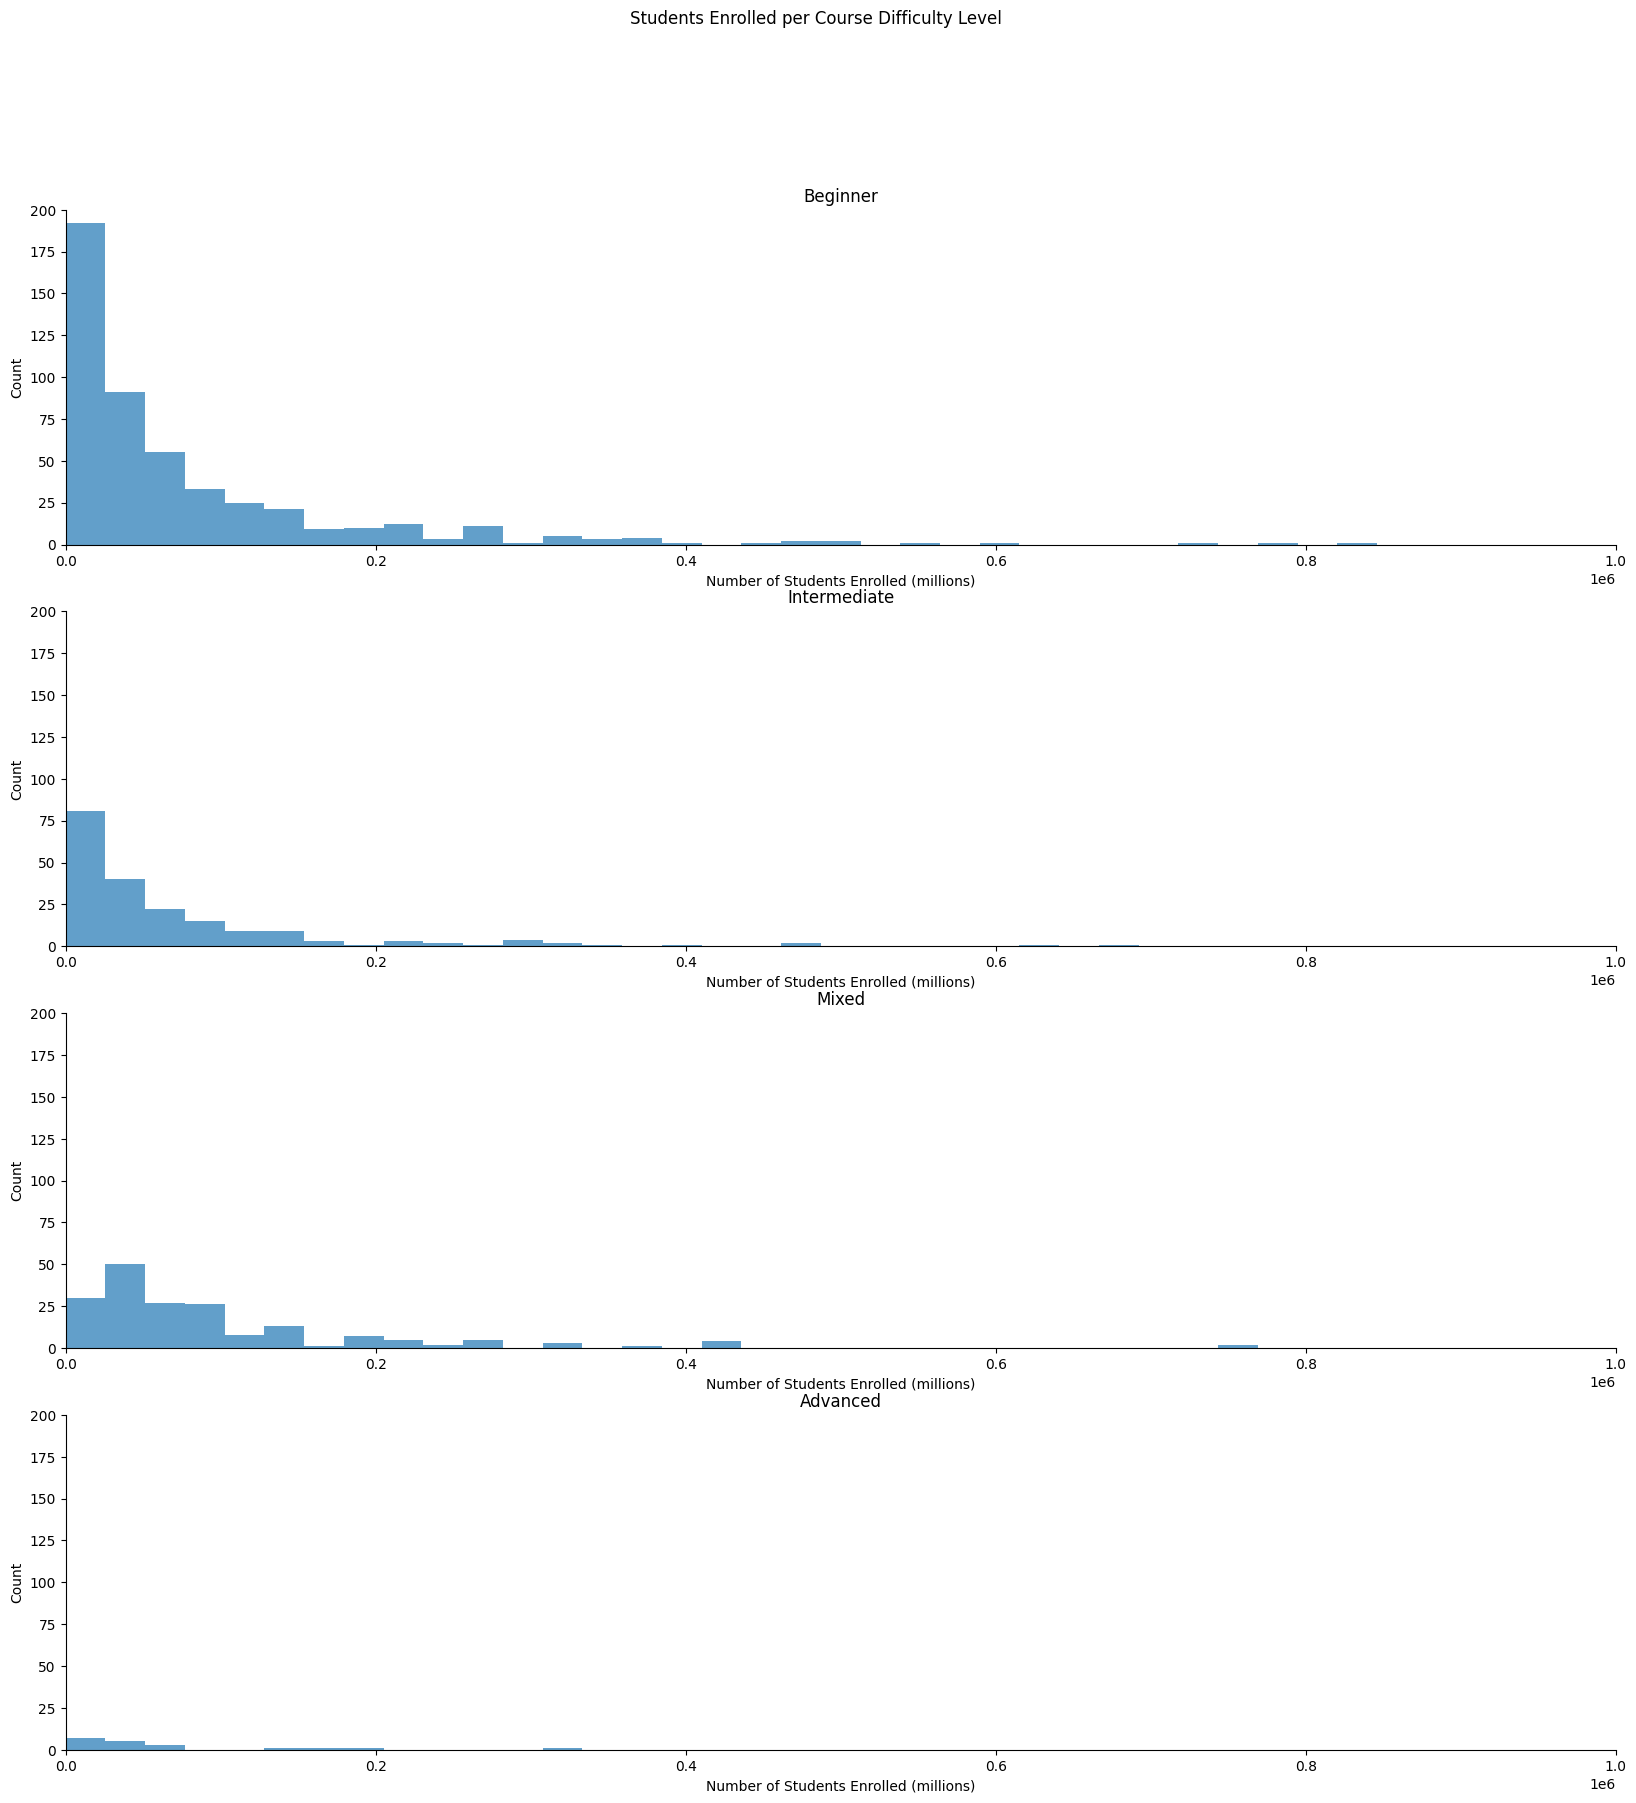

In [21]:
def hist_x_by_y(df,x,y,fig_title,xlabel,ylabel,bins=None,ylim=None,xlim=None,figsize=(20,20)):
    xs = df[y].unique()
    fig, ax = plt.subplots(len(xs),1,figsize=figsize)
    for i in range(len(xs)):
    
        ax[i].hist(df[df[y] == xs[i]]
        [x], histtype='stepfilled', bins=bins, alpha=0.7)
        ax[i].set_ylim(ylim)
        ax[i].set_xlim(xlim)
        ax[i].set_title(f'{xs[i]}'.capitalize())
        ax[i].spines[['top','right']].set_visible(False)
        ax[i].set_ylabel(xlabel)
        ax[i].set_xlabel(ylabel)
    fig.suptitle(fig_title);
        
hist_x_by_y(data,'course_students_enrolled_numeric','course_difficulty',ylabel='Number of Students Enrolled (millions)',xlabel='Count',
            bins=np.linspace(0,1E6,40),ylim=(0,200),xlim=(0,1E6,),
           fig_title='Students Enrolled per Course Difficulty Level')


No interesting phenomena.

# Certificates

## Certificate Type Distribution

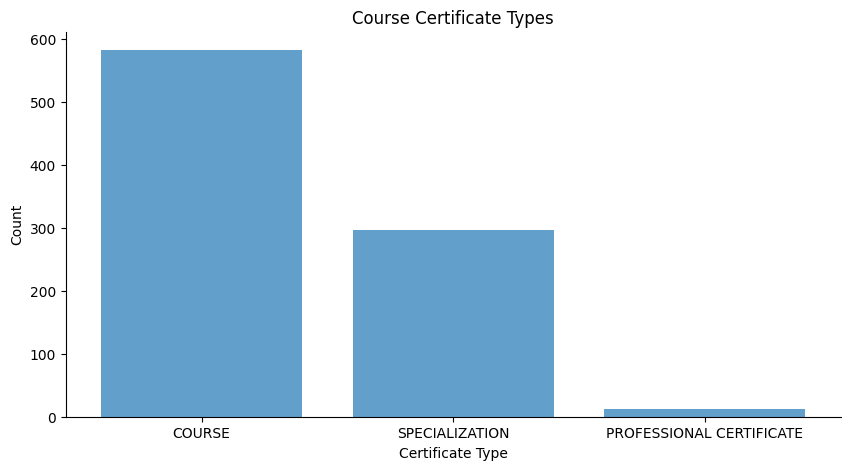

In [22]:
certificate_count = data['course_Certificate_type'].value_counts()
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(certificate_count.index, certificate_count, alpha=0.7)
ax.spines[['top','right']].set_visible(False)
ax.set_title('Course Certificate Types')
ax.set_ylabel('Count')
ax.set_xlabel('Certificate Type');

## Mean and Median Total Number of Enrollments by Certificate Type

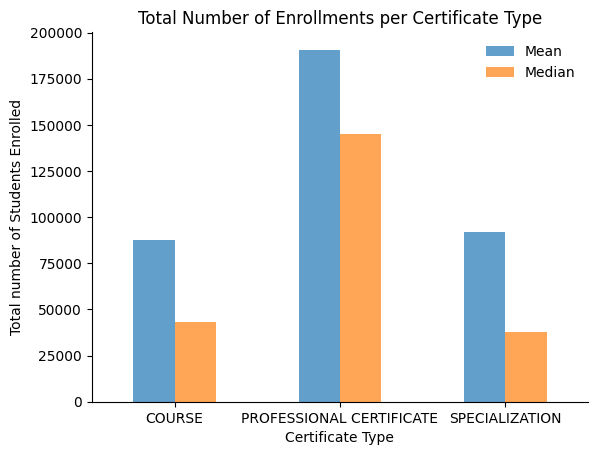

In [23]:
mean_enrollment_by_cert_type = data.groupby('course_Certificate_type')['course_students_enrolled_numeric'].mean()
median_enrollment_by_cert_type = data.groupby('course_Certificate_type')['course_students_enrolled_numeric'].median()
mean_median_en_by_cert = pd.DataFrame({'Mean' : mean_enrollment_by_cert_type.values,
                                      'Median' : median_enrollment_by_cert_type.values},
                                      index=mean_enrollment_by_cert_type.index)
ax = mean_median_en_by_cert.plot(kind='bar', rot=0, alpha=0.7)
ax.set_xlabel('Certificate Type')
ax.spines[['top','right']].set_visible(False)
ax.get_legend().draw_frame(False);
ax.set_title('Total Number of Enrollments per Certificate Type')
ax.set_ylabel('Total number of Students Enrolled');

Quite surprisingly the mean and median numbers for professional certificates go way beyond the course and specialization types.
However, the fraction of courses that do professional certificates is very small, therefore, these results are very unreliable.

In [24]:
data[data['course_Certificate_type'] == 'PROFESSIONAL CERTIFICATE']

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric
65,Arizona State University TESOL,Arizona State University,PROFESSIONAL CERTIFICATE,4.9,Beginner,150k,150000.0
142,Cloud Engineering with Google Cloud,Google Cloud,PROFESSIONAL CERTIFICATE,4.7,Intermediate,310k,310000.0
192,Data Engineering with Google Cloud,Google Cloud,PROFESSIONAL CERTIFICATE,4.6,Intermediate,120k,120000.0
391,Google IT Automation with Python,Google,PROFESSIONAL CERTIFICATE,4.7,Beginner,93k,93000.0
392,Google IT Support,Google,PROFESSIONAL CERTIFICATE,4.8,Beginner,350k,350000.0
416,IBM AI Engineering,IBM,PROFESSIONAL CERTIFICATE,4.6,Intermediate,140k,140000.0
418,IBM Applied AI,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,220k,220000.0
420,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480k,480000.0
709,SAS Programmer,SAS,PROFESSIONAL CERTIFICATE,4.8,Beginner,370k,370000.0
710,SAS Visual Business Analytics,SAS,PROFESSIONAL CERTIFICATE,4.6,Beginner,2.6k,2600.0


It seems that the reason that professional certificate courses had central measures way above the rest of certificate types is the confounding variable of course organization, since most of the courses in this category were published by Google and IBM.

# Ratings

### Rating Distribution

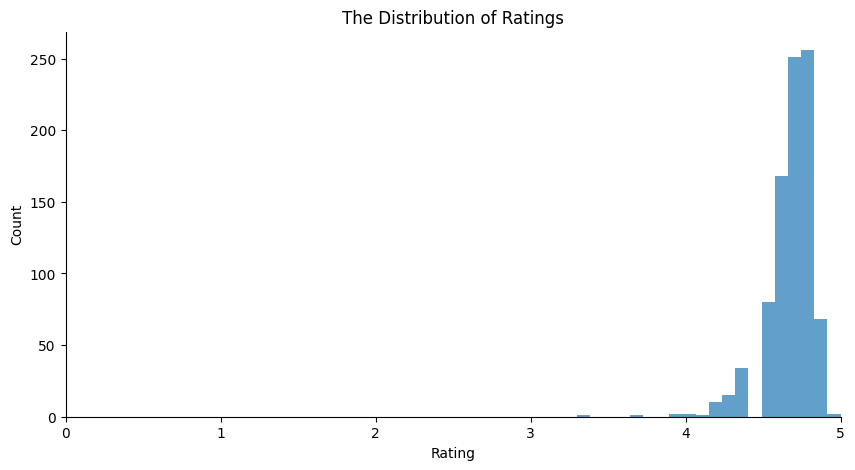

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(data['course_rating'],bins=20, alpha=0.7)
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0,5)
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.set_title('The Distribution of Ratings');

The rating data is slightly skewed yet with most rating lying between 4.5 and 5.

## Ratings Distributions of Different Certificate Types

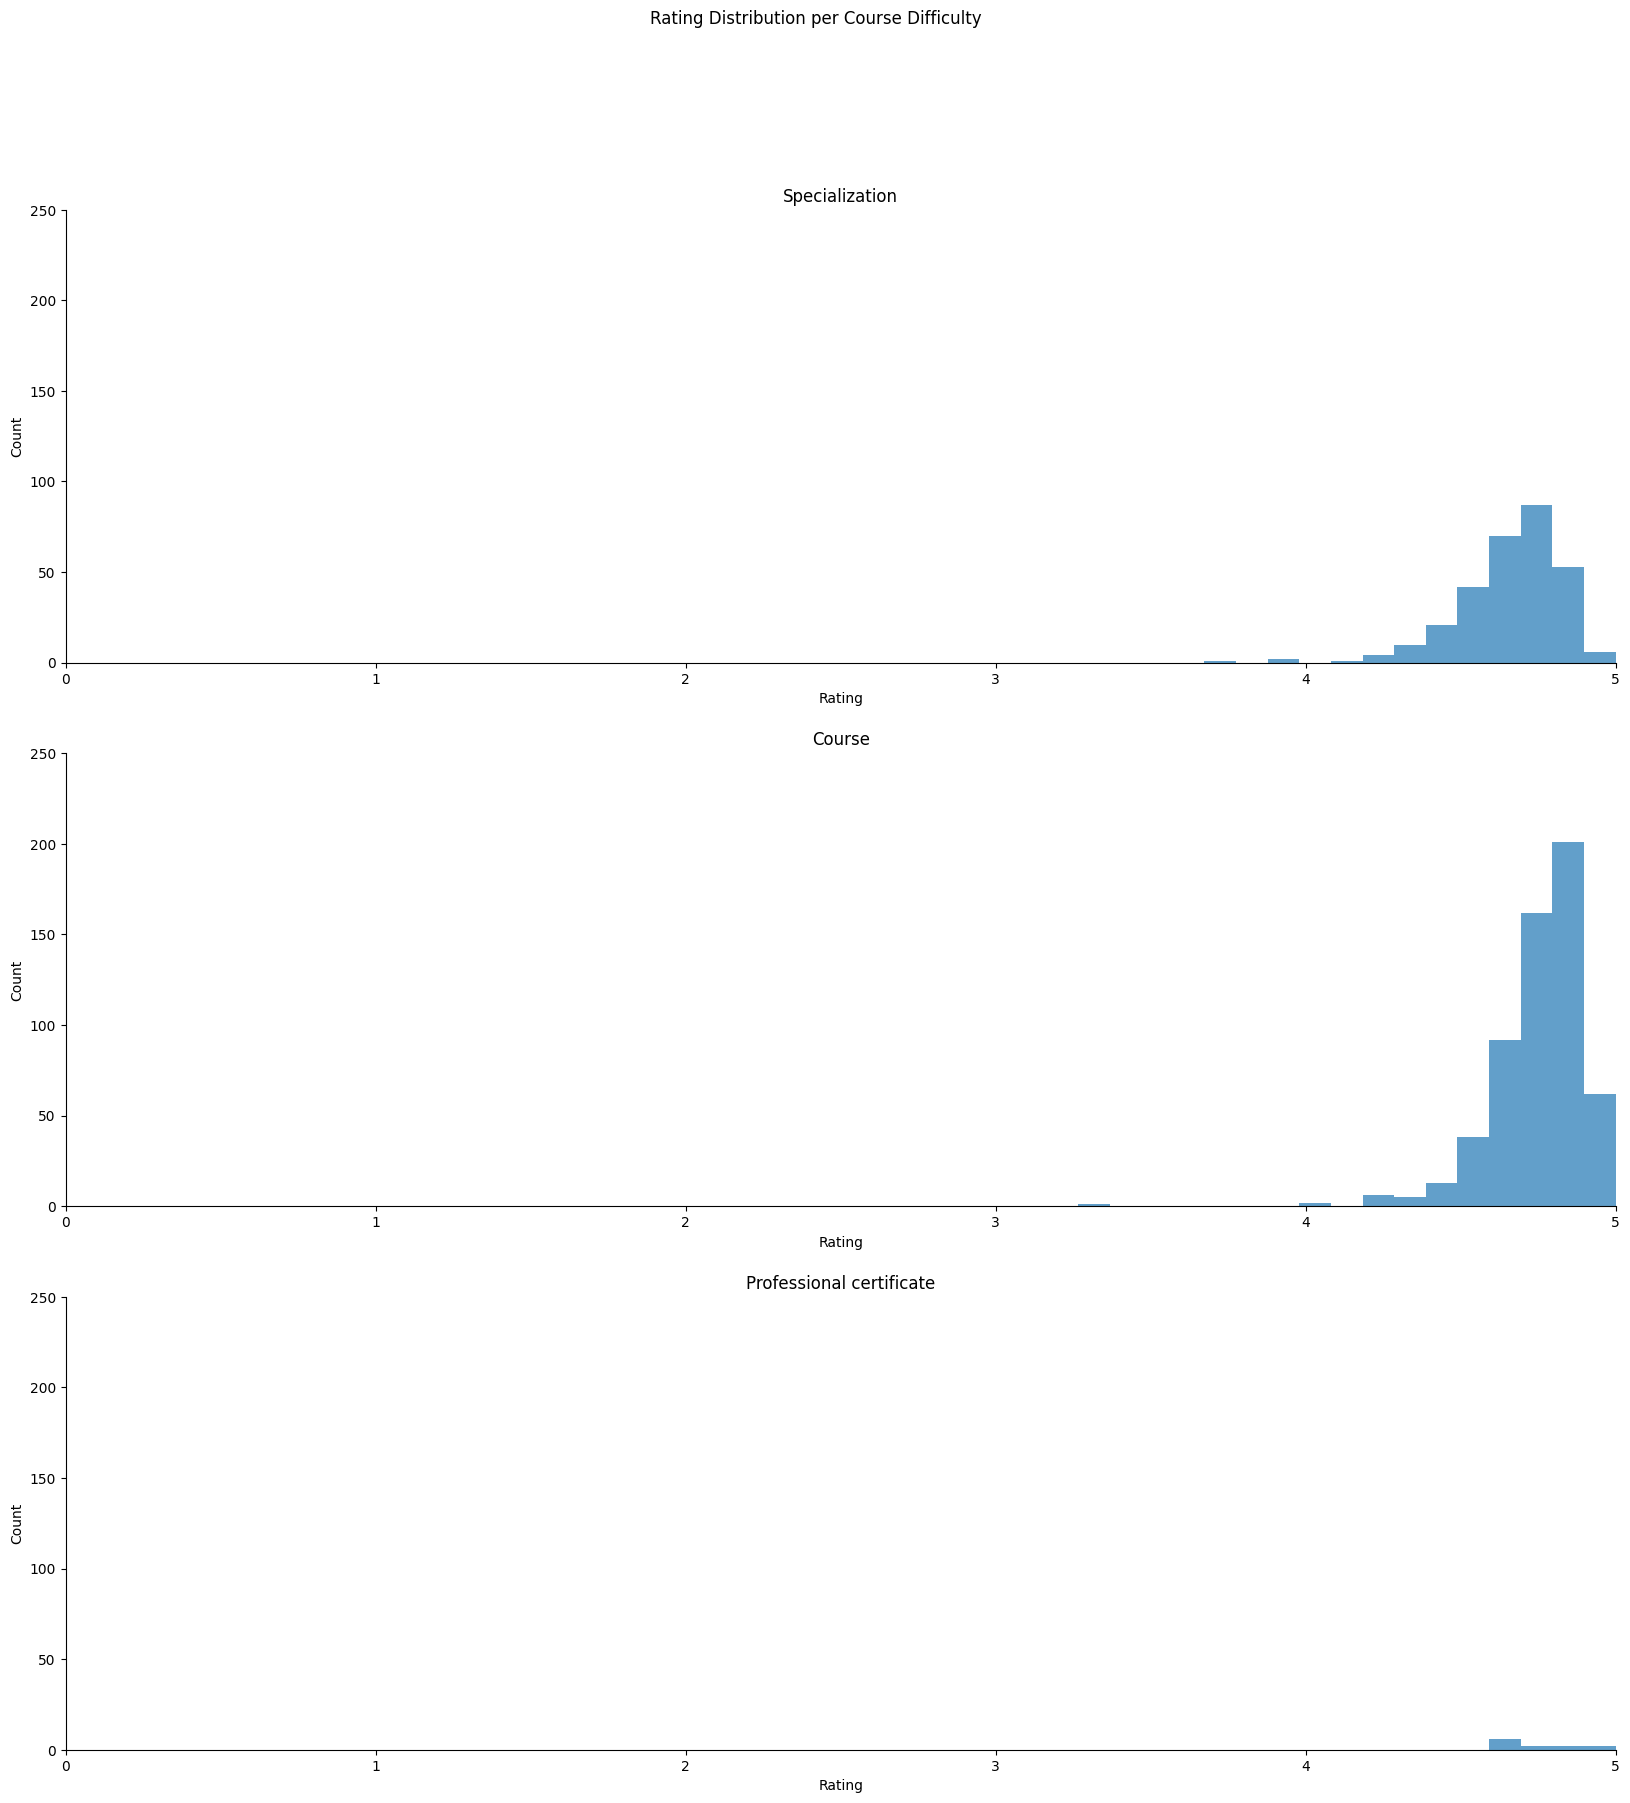

In [26]:
hist_x_by_y(data,'course_rating','course_Certificate_type',
            bins=np.linspace(0,5,50),ylim=(0,250),xlim=(0,5),
            fig_title='Rating Distribution per Course Difficulty',
            ylabel='Rating',xlabel='Count')

Generally people taking specialization courses seem to give feedback more critically given the differences between the right side of the curve in Course and Specialization categories.

## Rating per Course Difficulty

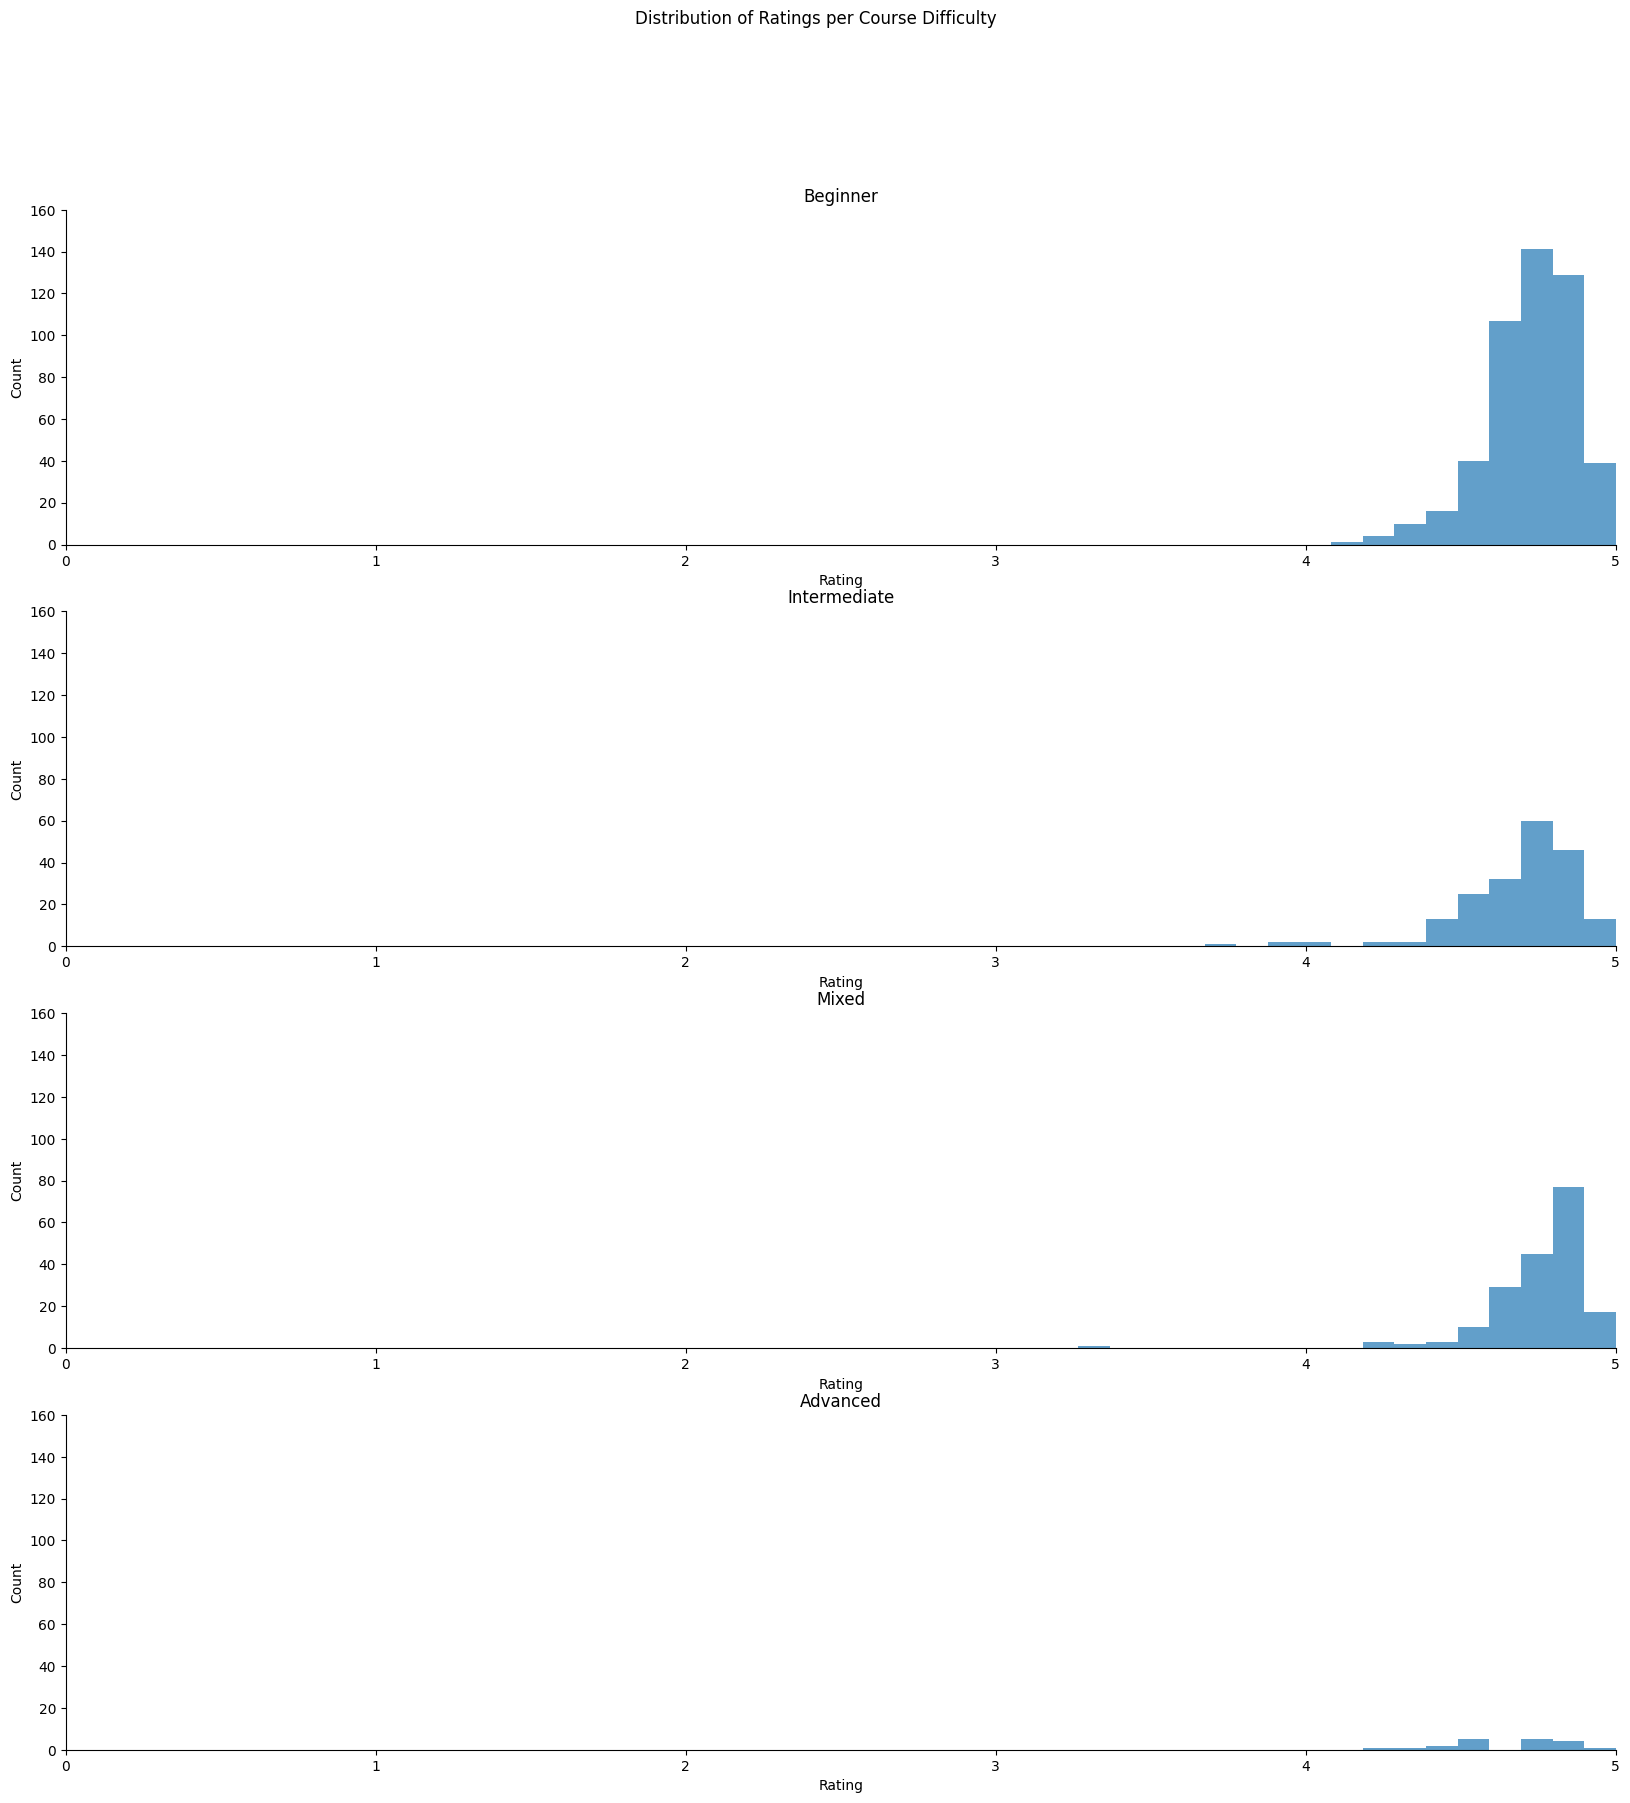

In [27]:
hist_x_by_y(data,'course_rating','course_difficulty',bins=np.linspace(0,5,50),ylim=(0,160),xlim=(0,5),
            fig_title='Distribution of Ratings per Course Difficulty',
            xlabel='Count', ylabel='Rating')

Generally quite similar distributions of ratings. Advanced category is not very useful due to low amount of entries.

# Organization Type

Deriving the types of organizations from 'course_organization' column.

Selecting some keywords:

In [28]:
data[np.invert(data['course_organization'].str.contains(
'|'.join(['Universi', 'Institute', 'School','College'])))]['course_organization'].unique()

array(['(ISC)²', 'deeplearning.ai', 'IBM', 'Amazon Web Services',
       'Google Cloud', 'Atlassian', 'ScrumTrek',
       'The Museum of Modern Art', 'National Arts Strategies', 'Autodesk',
       'Google - Spectrum Sharing', 'INSEAD', 'ConsenSys Academy',
       'HEC Paris', 'Osmosis', 'Cisco', 'LearnQuest', 'Google', 'PwC',
       'Ticket for Change', 'Tecnológico de Monterrey',
       'American Museum of Natural History',
       'École Polytechnique Fédérale de Lausanne', 'Sciences Po',
       'Bloomsbury Learning Exchange', 'SAS', 'Automation Anywhere',
       'Kalshoven-Gieskes Forum', 'JetBrains', 'Cloudera', 'VMware',
       'The Linux Foundation', 'Palo Alto Networks', 'MathWorks',
       'E-Learning Development Fund', 'BCG', 'HubSpot Academy',
       'Crece con Google', 'Fundação Instituto de Administração',
       'École des Ponts ParisTech', 'Unity', 'École Polytechnique',
       'Mail.Ru Group'], dtype=object)

Making sure that 'School' keyword links to actual higher education schools:

In [29]:
data[data['course_organization'].str.contains('School')]['course_organization'].unique()

array(['Indian School of Business',
       'National Research University Higher School of Economics',
       'Copenhagen Business School', 'London Business School',
       'IE Business School', 'IESE Business School',
       'UCL School of Management', 'ESADE Business and Law School',
       'EDHEC Business School', 'ESSEC Business School',
       'ESCP Business School', 'IE School of Architecture & Design',
       'Icahn School of Medicine at Mount Sinai',
       'Relay Graduate School of Education'], dtype=object)

Keywords: INSEAD, HEC Paris, Tecnológico de Monterrey, École, Fundação Instituto de Administração were checked and excluded manually:

In [30]:
keywords = ['Universi', 'Institute', 'School','College',
'INSEAD', 'HEC Paris', 'Tecnológico de Monterrey', 'École',
'Fundação Instituto de Administração']

non_unis = data[np.invert(data['course_organization'].str.contains(
'|'.join(keywords)))]['course_organization'].unique()

In [31]:
non_unis

array(['(ISC)²', 'deeplearning.ai', 'IBM', 'Amazon Web Services',
       'Google Cloud', 'Atlassian', 'ScrumTrek',
       'The Museum of Modern Art', 'National Arts Strategies', 'Autodesk',
       'Google - Spectrum Sharing', 'ConsenSys Academy', 'Osmosis',
       'Cisco', 'LearnQuest', 'Google', 'PwC', 'Ticket for Change',
       'American Museum of Natural History', 'Sciences Po',
       'Bloomsbury Learning Exchange', 'SAS', 'Automation Anywhere',
       'Kalshoven-Gieskes Forum', 'JetBrains', 'Cloudera', 'VMware',
       'The Linux Foundation', 'Palo Alto Networks', 'MathWorks',
       'E-Learning Development Fund', 'BCG', 'HubSpot Academy',
       'Crece con Google', 'Unity', 'Mail.Ru Group'], dtype=object)

In [32]:
data['organization_type'] = np.where(data['course_organization'].isin(non_unis),'Other','Higher Education')
data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric,organization_type
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k,5300.0,Other
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k,17000.0,Higher Education
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k,130000.0,Higher Education
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k,91000.0,Higher Education
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k,320000.0,Higher Education


## Certificate Type Distribution by Organization Type

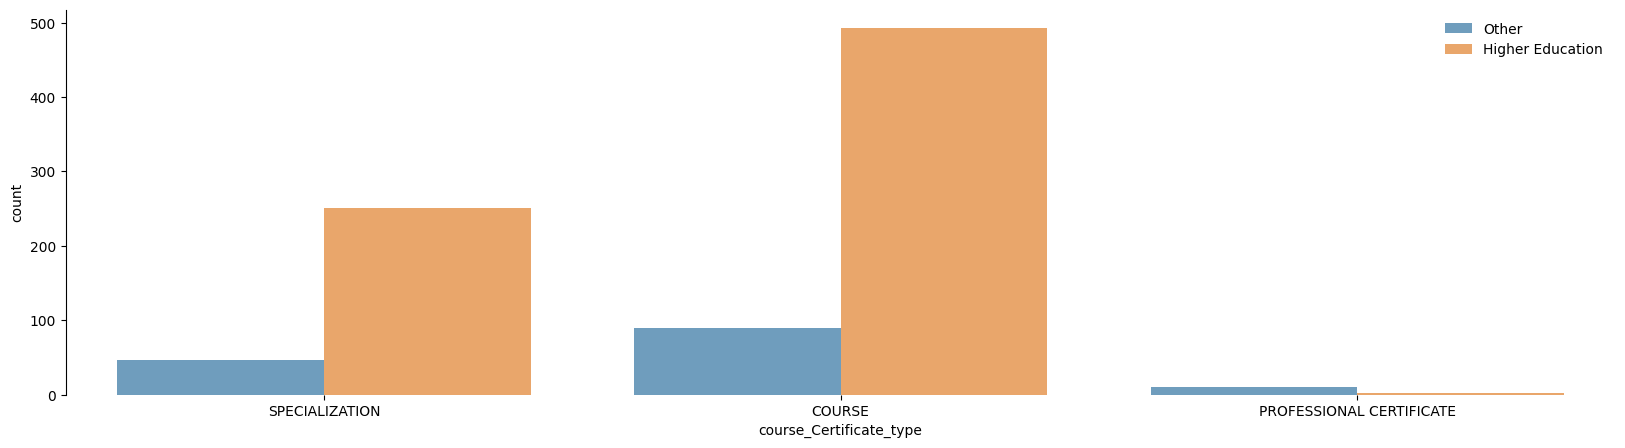

In [33]:
ax = sns.countplot(data=data,x='course_Certificate_type',hue='organization_type',alpha=0.7)
plt.gcf().set_size_inches(20,5)
ax.spines[['top','right','bottom']].set_visible(False)
ax.get_legend().set(title='',frame_on=False);

Higher education institutions dominate the course and specialization categories, while other institutions have a slight lead on professional certification. Yet again the lack of data needs to be taken into account.

## Rating Distribution by Organization Type

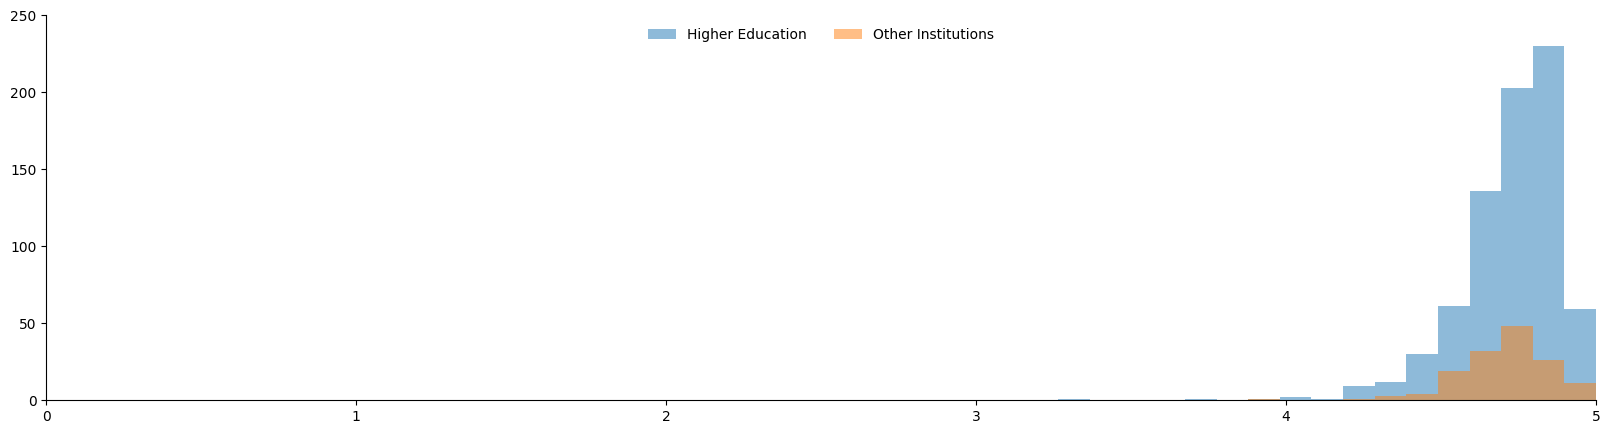

In [34]:
fig, ax = plt.subplots(figsize=(20,5))

ax.hist(data[data['organization_type'] == 'Higher Education']['course_rating'],
alpha=0.5, label='Higher Education',bins=np.linspace(0,5,50))

ax.hist(data[data['organization_type'] == 'Other']['course_rating'],alpha=0.5,label='Other Institutions',
bins=np.linspace(0,5,50))

leg = ax.legend(frameon=False, loc='upper center', ncol=2)
ax.set_xlim(0,5)
ax.set_ylim(0,250)
ax.spines[['top','right']].set_visible(False);

Higher education has more skewed distribution with the bigger concentration of higher values to the right. But otherwise both categories are quite similarly distributed.

## Enrollment Distribution per Organization Type

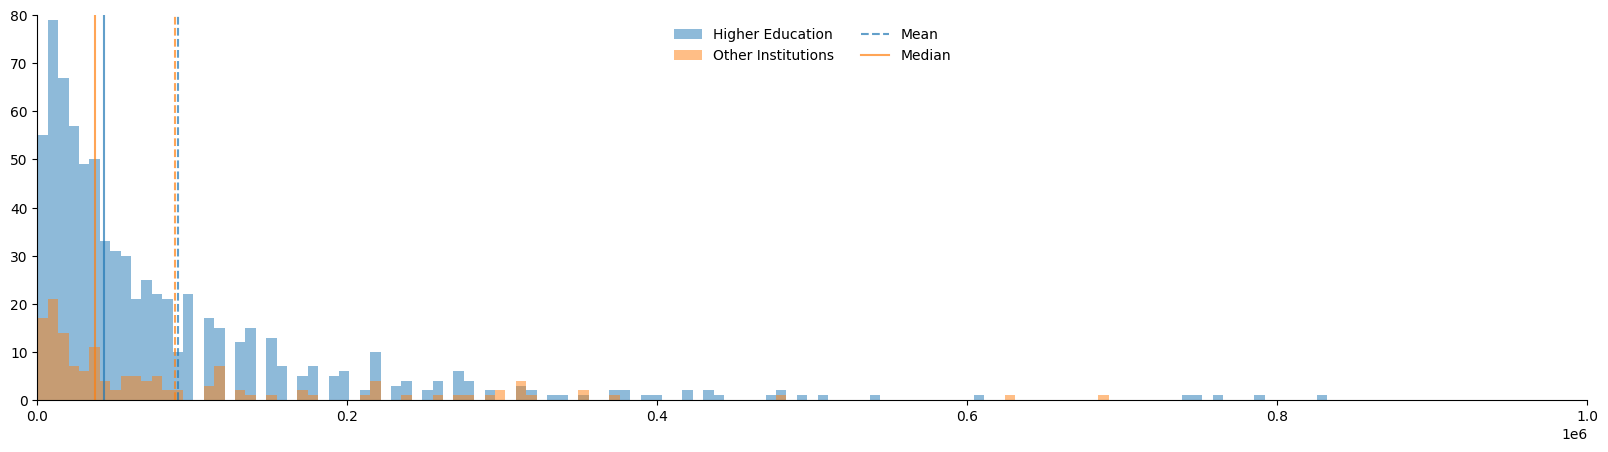

In [35]:
fig, ax = plt.subplots(figsize=(20,5))

ax.hist(data[data['organization_type'] == 'Higher Education']['course_students_enrolled_numeric'],
alpha=0.5, label='Higher Education',bins=np.linspace(0,1E6,150))

ax.hist(data[data['organization_type'] == 'Other']['course_students_enrolled_numeric'],alpha=0.5,label='Other Institutions',
bins=np.linspace(0,1E6,150))

ax.axvline(np.mean(data[data['organization_type'] == 'Higher Education']['course_students_enrolled_numeric']),linestyle='--', alpha=0.7, label='Mean')
ax.axvline(np.median(data[data['organization_type'] == 'Higher Education']['course_students_enrolled_numeric']),alpha=0.7)
ax.axvline(np.mean(data[data['organization_type'] == 'Other']['course_students_enrolled_numeric']),linestyle='--', alpha=0.7, color='#ff7f0e')
ax.axvline(np.median(data[data['organization_type'] == 'Other']['course_students_enrolled_numeric']),alpha=0.7,color='#ff7f0e',label='Median')

leg = ax.legend(frameon=False, loc='upper center', ncol=2)
ax.set_xlim(0,1E6)
ax.set_ylim(0,80)
ax.spines[['top','right']].set_visible(False);

Very similar distribution overall. Higher education organizations have more outlying values.

## Course Difficulty Distribution by Organization Type

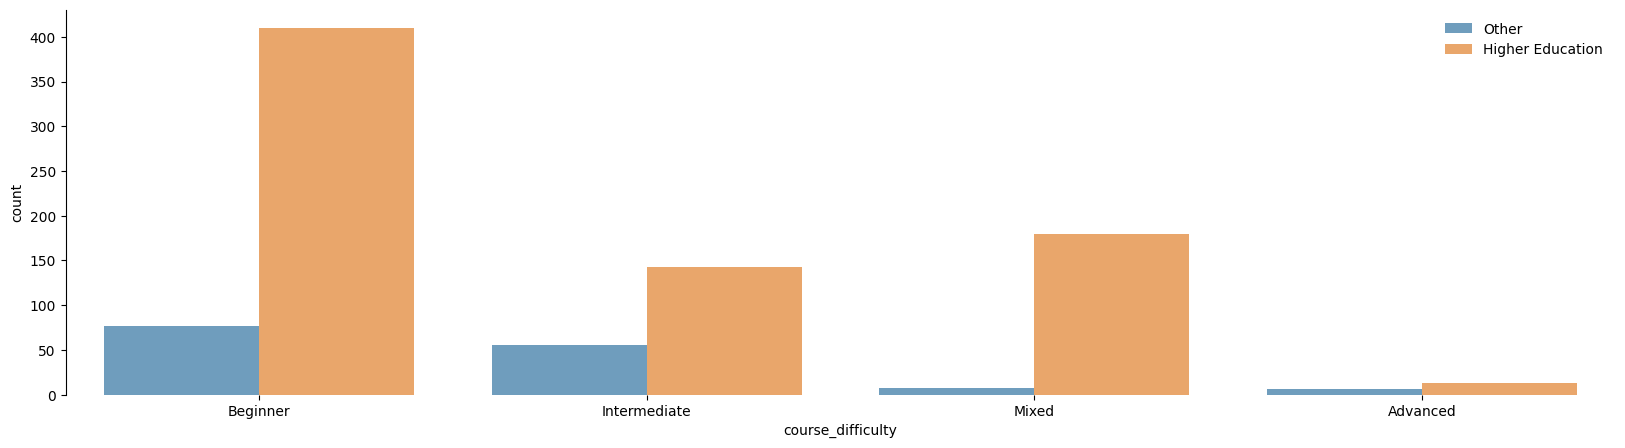

In [36]:
ax = sns.countplot(data=data,x='course_difficulty',hue='organization_type',alpha=0.7)
plt.gcf().set_size_inches(20,5)
ax.spines[['top','right','bottom']].set_visible(False)
ax.get_legend().set(title='',frame_on=False);

Higher education dominates all categories. Quite interestingly, in stark contrast to higher education institutions the mixed category has very few courses from other types of organizations.

# Conclusion

Given this data was scraped as an exercise in a hackaton it is quite unreliable. There are very few observations and few features to come up with meaningful insights. However one pattern that came up constantly during this analysis was the weight that certain educational institutions like prominent American Universities or biggest tech companies had on the popularity outcome. Understanding which kinds of institutions are most trusted by MOOC consumers would provide imense business value.